# 8. Transformers for Kubernetes Operations: Enhancing Prediction Accuracy with NLP

## Introduction

Welcome to the 8th notebook in our series on **AI for Kubernetes operations**! In the previous notebook, we explored the basics of **machine learning** and applied a **Decision Tree Classifier** to predict Kubernetes incidents. Now, we’ll dive deeper into a more advanced approach using **transformer models** like **BERT** to enhance the prediction accuracy for Kubernetes incidents.

Transformer models have revolutionized the field of Natural Language Processing (NLP) and can also be leveraged for tasks like classifying Kubernetes events based on operational metrics and logs. In this notebook, we will explore how to fine-tune a pre-trained transformer model, BERT (Bidirectional Encoder Representations from Transformers), for the task of event classification in Kubernetes operations.

By using BERT, we aim to leverage its ability to understand contextual relationships in text-based data to classify events more accurately and robustly.

### Objectives

By the end of this notebook, you will be able to:
- Understand the key concepts behind transformer models and BERT.
- Fine-tune a pre-trained BERT model on Kubernetes operational data.
- Evaluate the model's performance using standard classification metrics.
- Interpret results and visualize the predictions using confusion matrices and classification reports.

### Key Features

This notebook introduces:
- An introduction to **transformer models** and their applications in AI and NLP.
- A hands-on guide to **fine-tuning BERT** on Kubernetes operational data for event classification.
- Evaluation and interpretation of model performance:
  - Classification reports to understand model accuracy and performance.
  - Confusion matrices to identify misclassifications and improve model performance.


## 1. Installing the Required Libraries

Before we start, we need to install the necessary libraries. These include **transformers**, **torch**, and **scikit-learn**, which are required to build and fine-tune the BERT model. Run the following cell to install these libraries:

In [80]:
%pip install transformers torch scikit-learn matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


### System Information

In this section, we check the environment in which we are running the code. This includes the Python version, PyTorch version, and whether a compatible GPU or Apple MPS is available.

This helps us ensure that we are leveraging the best computational resources for model training and evaluation.

In [81]:
# What version of Python do you have?
import sys
import platform
import pandas as pd
import sklearn as sk
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

torch.cuda.empty_cache()

Python Platform: macOS-15.2-arm64-arm-64bit
PyTorch Version: 2.5.1

Python 3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]
Pandas 2.2.3
Scikit-Learn 1.6.1
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


## 2. Loading and Preparing the Dataset

In this section, we load the preprocessed Kubernetes dataset that contains event information and operational metrics. We combine the relevant event columns into a single target column (`event_message`) and encode it for use with BERT. 

This dataset will be used to fine-tune the BERT model for classifying Kubernetes events.

In [82]:
# Load dataset
file_path = "data/preprocessed_kubernetes_data.csv"  # Update with the correct path
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

## 3. Encoding the Target Labels

In this step, we transform the event labels (like `Normal`, `Warning`, `Error`) into numeric values. This transformation is necessary because machine learning models, including BERT, work with numerical data, not categorical strings.

- **Label Encoding**: The `LabelEncoder` from `sklearn` is used to convert the string labels into integers (e.g., `Normal` -> 0, `Warning` -> 1, `Error` -> 2). This allows the model to understand and process the data.
- **BERT Processing**: BERT and other machine learning models expect the target labels to be in a numerical format for tasks like classification. The encoding ensures that the model can learn to predict the correct event type.

By encoding the labels, we make the dataset ready for training with a machine learning model.

In [83]:
# Combine event-related columns into a single target column
event_columns = [
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
]

df["event_message"] = df[event_columns].idxmax(axis=1)  # get the event type
df["event_message"] = (
    df["event_message"].str.replace("event_message_", "").str.replace("event_type_", "")
)
df.drop(columns=event_columns, inplace=True)

In [84]:
label_encoder = LabelEncoder()
df["event_message_encoded"] = label_encoder.fit_transform(df["event_message"])

## 4. Selecting Features and Target Variable

In this section, we define the **features** (inputs) and the **target variable** (output) that our model will use for training.

- **Feature Selection**: The features describe the state of the system and its health. By selecting the right features, the model can learn patterns that help predict Kubernetes events.
- **Target Variable**: This tells the model what to predict (event type), and it is encoded numerically to make the data easier to work with.

Together, these features and the target variable provide the necessary data for the model to train and make predictions on Kubernetes events.

### Numerical Features
The features selected are important Kubernetes operational metrics, including:
- `cpu_allocation_efficiency`: How efficiently CPU resources are used.
- `memory_allocation_efficiency`: How efficiently memory is used.
- `disk_io`: Rate of data transfer to/from the disk.
- `network_latency`: Delay in network communication.
- `node_temperature`: Temperature of the node, which can affect performance.
- `node_cpu_usage`: Percentage of CPU used on the node.
- `node_memory_usage`: Amount of memory used on the node.

These features are essential because they help the model understand the conditions in which various Kubernetes events (such as `Normal`, `Warning`, or `Error`) occur.

### Target Variable
The target variable, `event_message_encoded`, represents the event type (e.g., `Normal`, `Warning`, `Error`). The target is encoded into numerical values so that the model can learn to predict event types.

In [85]:
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
]

# Select features
X = df[numerical_features]
y = df["event_message_encoded"]

## 5. Tokenizing the Event Messages

In this step, we prepare the text data (event messages) for input into the BERT model by using the **BERT tokenizer**. The tokenizer converts the raw text into token IDs that represent words or subwords, allowing BERT to process the text.

- **BERT Tokenizer**: The tokenizer splits the event messages into subwords or words and then converts them into corresponding token IDs. This is necessary because BERT understands the text in the form of token IDs, not raw text.
- **Padding**: Since BERT expects all input sequences to be of the same length, we apply padding to ensure that all event messages are of uniform length (e.g., 128 tokens). If a message is shorter, it is padded with zeros to match the desired length.
- **Attention Masks**: Attention masks indicate which tokens are actual data (1) and which ones are padding (0). This helps the model focus on the real tokens during processing and ignore the padding tokens.

By tokenizing, padding, and creating attention masks, we prepare the text data in a format that BERT can efficiently process for classification tasks.

In [86]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the event message (for BERT)
X_text = df["event_message"].apply(
    lambda x: tokenizer.encode(x, truncation=True, padding="max_length", max_length=128)
)

In [87]:
# Padding and attention mask
def create_attention_mask(input_ids):
    attention_mask = [1 if token_id > 0 else 0 for token_id in input_ids]
    return attention_mask


X_text_pad = torch.tensor(
    [x + [0] * (128 - len(x)) if len(x) < 128 else x[:128] for x in X_text]
)  # Padding
attention_masks = torch.tensor([create_attention_mask(x) for x in X_text_pad])

## 6. Training the BERT Model

In this step, we initiate the **training process** for the BERT model. The model learns to classify Kubernetes events based on operational metrics by adjusting its weights to minimize prediction errors.

### Key Components of the Training Process:
- **Training Loop**: The model is trained over multiple epochs, where each epoch consists of several batches of data. During each epoch, the model learns from the training data and updates its parameters to improve performance.
- **tqdm**: We use **tqdm** to track the progress of the training loop. It provides a progress bar that shows the number of batches processed, the current epoch, and key metrics such as loss and accuracy.
- **Loss Function**: We use **CrossEntropyLoss** as the loss function. This function computes the difference between the predicted class probabilities and the actual labels, guiding the model in adjusting its parameters to minimize the error.
- **Accuracy Calculation**: After each epoch, we calculate the model’s accuracy by comparing its predictions with the true labels. This helps us monitor the model's performance over time.

During training, the model adjusts its internal weights to better understand how operational metrics influence event types, improving its ability to classify Kubernetes incidents accurately.

## 6.1. Splitting the Data into Training and Testing Sets

In this step, we **split the dataset** into two parts: one for training the model and another for testing its performance. This is essential to evaluate how well the model generalizes to unseen data.

### Key Actions:
- **train_test_split**: We use the `train_test_split` function from **scikit-learn** to randomly divide the data into training and testing sets. The training set is used to teach the model, while the testing set is used to evaluate the model's performance. We allocate 80% of the data for training and 20% for testing, ensuring a balanced split.
  
- **TensorDataset**: We convert the data into **TensorDataset** objects, which are compatible with PyTorch’s **DataLoader**. This allows the model to efficiently access the training and testing data during training and evaluation.
  
- **DataLoader**: The **DataLoader** provides an iterable over the dataset, splitting it into batches of a specified size (32 in this case). This is crucial for handling large datasets, as it allows the model to process data in manageable chunks, updating its weights incrementally.

This step prepares the data for feeding into the BERT model, ensuring that the model can efficiently process both the text data and the operational metrics.

In [88]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_text_pad, y, test_size=0.2, random_state=42, shuffle=True
)

# Convert to TensorDataset for DataLoader
train_data = TensorDataset(
    X_train, attention_masks[: len(X_train)], torch.tensor(y_train.values)
)
test_data = TensorDataset(
    X_test, attention_masks[len(X_train) :], torch.tensor(y_test.values)
)

# Create DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32)

## 6.2. Initializing the BERT Model for Sequence Classification

In this step, we initialize the **BERT model** to perform sequence classification, which is essential for classifying the Kubernetes event types based on the input data.

### Key Actions:
- **BERT Model Initialization**: We load a pre-trained version of **BERT** (`bert-base-uncased`) using the `BertForSequenceClassification` class. This class is specifically designed for text classification tasks. We set the `num_labels` argument to match the number of unique event types, ensuring the model outputs the correct number of class predictions (e.g., Normal, Warning, Error).
  
- **Adam Optimizer**: The **AdamW** optimizer is used to update the model’s weights during training. We set the learning rate to `1e-5` to ensure the model learns effectively without overshooting the optimal weights. Adam is widely used for its ability to adapt the learning rate for each parameter.
  
- **Moving to GPU/CPU**: The model is moved to the available device (GPU or CPU) using `model.to(device)`. This is important because training deep learning models can be computationally intensive, and using a GPU can significantly speed up the process.

By setting up the BERT model in this way, we are ready to begin training it on the dataset to classify the Kubernetes events based on both the text and operational features.

In [89]:
# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)

# Use Adam optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Move the model to GPU if available
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 6.3. Training the BERT Model

Now, we proceed with the training of the BERT model using the dataset. The training loop involves multiple key steps to update the model’s parameters and evaluate its performance.

### Key Steps:
1. **Optimizer and Loss Function Setup**:
   - We use the **AdamW** optimizer with a learning rate of `2e-5`. This optimizer adapts the learning rate for each model parameter, helping the model converge efficiently during training.
   - The **CrossEntropyLoss** function is chosen as the loss function, which is suitable for multi-class classification tasks like predicting the Kubernetes event type.

2. **Epoch Loop**:
   - The model is trained for a total of **3 epochs**. Each epoch represents a complete pass through the training data. During each epoch, the model learns from the training data and adjusts its weights to minimize the loss.
   
3. **Training Data Loop**:
   - For each batch in the **training data**, we:
     - Transfer the data to the GPU or CPU (`to(device)`).
     - Perform a **forward pass** through the model to get the predicted logits (raw outputs from the model).
     - **Calculate the loss** by comparing the predicted logits with the true labels.
     - Perform a **backward pass** to compute gradients and **update the model's weights** using the optimizer.

4. **Tracking Performance**:
   - We track the running loss and accuracy throughout the training loop. The **accuracy** is calculated by comparing the predicted labels (`preds`) with the true labels (`labels`) in each batch.
   - After each epoch, the average loss and accuracy for the epoch are displayed, providing feedback on the model’s progress.

5. **Validation (optional)**:
   - After training each epoch, we evaluate the model on the **test dataset**. This helps check how well the model generalizes to unseen data.
   - We calculate **validation loss** and **validation accuracy** in the same way as during training.

This process allows the model to progressively learn from the data, improving its ability to classify Kubernetes events correctly over time.

In [90]:
from tqdm import tqdm  # Import tqdm

model.to(device)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Number of epochs
epochs = 3

# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Loop through training data with progress bar
    for batch in tqdm(
        train_dataloader, desc=f"Training Epoch {epoch + 1}", unit="batch"
    ):
        # Get the data for the current batch
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = loss_fn(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()

        # Get predictions and calculate accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    # Calculate and print the epoch loss and accuracy
    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation (optional)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        for batch in tqdm(test_dataloader, desc="Validating", unit="batch"):
            input_ids, attention_mask, labels = [item.to(device) for item in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            val_correct_predictions += torch.sum(preds == labels)
            val_total_predictions += labels.size(0)

        avg_val_loss = val_loss / len(test_dataloader)
        val_accuracy = val_correct_predictions / val_total_predictions
        print(
            f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}"
        )

Training Epoch 1: 100%|██████████| 375/375 [02:50<00:00,  2.20batch/s]


Epoch 1 - Loss: 0.1112, Accuracy: 0.9852


Validating: 100%|██████████| 94/94 [00:13<00:00,  6.93batch/s]


Validation Loss: 0.0034, Validation Accuracy: 1.0000


Training Epoch 2: 100%|██████████| 375/375 [03:18<00:00,  1.89batch/s]


Epoch 2 - Loss: 0.0031, Accuracy: 1.0000


Validating: 100%|██████████| 94/94 [00:14<00:00,  6.33batch/s]


Validation Loss: 0.0012, Validation Accuracy: 1.0000


Training Epoch 3: 100%|██████████| 375/375 [03:19<00:00,  1.88batch/s]


Epoch 3 - Loss: 0.0014, Accuracy: 1.0000


Validating: 100%|██████████| 94/94 [00:15<00:00,  5.90batch/s]

Validation Loss: 0.0007, Validation Accuracy: 1.0000


## 7. Evaluating the Model

Once the model is trained, it's crucial to evaluate its performance on the **test set**. This evaluation helps us understand how well the model generalizes to new, unseen data. The two primary tools we use for evaluating model performance are **classification reports** and **confusion matrices**.


2. **Confusion Matrix**:
   - The confusion matrix visualizes the model’s prediction errors and successes. It shows how many instances from each class were correctly predicted (True Positives and True Negatives) and how many were misclassified (False Positives and False Negatives).
   - By examining the confusion matrix, we can identify which event types the model struggles to classify, giving insight into areas where the model needs improvement.

By analyzing the classification report and confusion matrix, we can assess the model's overall effectiveness, detect potential issues like class imbalances, and refine the model further.

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Mapping back the numeric predictions to original class labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

### 7.1. Classification Report

- The classification report provides a detailed breakdown of the model’s performance across each class (in this case, the different event types).
- It includes metrics like **precision**, **recall**, **f1-score**, and **support**:
    - **Precision**: The percentage of positive predictions that are correct.
    - **Recall**: The percentage of actual positive instances that were correctly identified.
    - **F1-score**: The harmonic mean of precision and recall, providing a single metric that balances both.
    - **Support**: The number of occurrences of each class in the dataset.

In [92]:
# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

   Completed       1.00      1.00      1.00       608
      Failed       1.00      1.00      1.00       593
      Killed       1.00      1.00      1.00       574
   OOMKilled       1.00      1.00      1.00       621
     Started       1.00      1.00      1.00       604

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



### 7.2. Confusion Matrix:

- The confusion matrix visualizes the model’s prediction errors and successes. It shows how many instances from each class were correctly predicted (True Positives and True Negatives) and how many were misclassified (False Positives and False Negatives).
- By examining the confusion matrix, we can identify which event types the model struggles to classify, giving insight into areas where the model needs improvement.

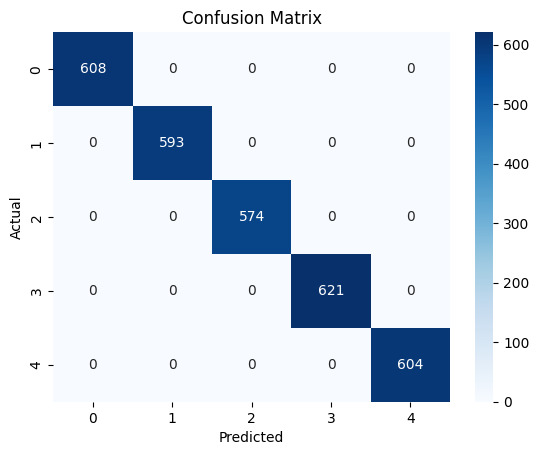

In [93]:
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Conclusion

In this notebook, we leveraged **BERT**, a powerful transformer model, to classify Kubernetes events. We fine-tuned the model using operational metrics and event data and evaluated its performance using standard classification metrics like accuracy, precision, and recall.

### Key Takeaways:
- **BERT** is highly effective at capturing contextual relationships in text and can be applied to a wide range of event classification tasks.
- The model was evaluated using **classification reports** and **confusion matrices** to understand its accuracy and identify potential improvements.
- Fine-tuning transformer models like BERT offers significant advantages over traditional machine learning models, particularly when working with text data.

### What's Next?
In the next notebook, we will explore more advanced transformer models and their applications in Kubernetes operations. We will also experiment with different architectures to improve classification performance.
